# All Mart - High Value Customer Identification

Identificação de clientes mais valiosos de uma empresa e projecção de um programa de fidelidade para os mesmos.

# Planejamento da Solução (IOT)

## Input - Entrada

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de Fidelização
2. Conjunto de dados
     - Vendas de um e-commerce online, durante o período de um ano.

## Output - Saída

1. A indicação das pessoas que farão parte do programa de _insiders_
    - Lista: cliente_id | is_insider | 
    

2. Relatório com as respostas das perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa insiders?
    - Quantos clientes farõa parte do grupo?
    - Quais as principais características desses clientes?
    - Qual a porcentagem de contribuição do faturamento, vinda do programa?
    - Qual a expectativa de faturamento (LTV) desse grupo para os próximos meses?
    - Quais as condições para uma pessoa ser elegível aos insiders?
    - Quais as condições para um apessoa ser removida dos insiders?
    - Qual a garantia que o programa _insiders_ é melhor que o restante da base?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa insiders?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto Ticket médio
        - Alto LTV (LifeTime Value)
        - Baixa Recência
        - Alto "Basket Size" (cesta de compra)
        - Baixa probabilidade de Churn
        - Alta Previsão de LTV 
        - Alta propensão de compra
        
    - Custo:
        - Baixa taxa de devolução

    - Experiência de compra:
        - Alta média de avaliações
    
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo _Insiders_
3. Quais as principais características desses clientes?
    - Idade
    - Localização
    
4. Qual a porcentagem de contribuição do faturamento, vinda do programa?
    - Faturamento total do ano
    - Faturamento do grupo _Insiders_
    
5. Qual a expectativa de faturamento (LTV) desse grupo para os próximos meses?
    - LTV do grupo _Insiders_
    - Análise de Cohort
    
6. Quais as condições para uma pessoa ser elegível aos insiders?
    - Definir a periodicidade (1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa grupo
    
7. Quais as condições para um apessoa ser removida dos insiders?
    - Definir a periodicidade (1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa grupo

8. Qual a garantia que o programa _insiders_ é melhor que o restante da base?
    - Teste de hipóteses
    - Teste A/B bayesiano
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Produtos exclusivos

# 0.0 Imports

In [1]:
# !pip install pandas_profiling

In [93]:
# from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random, os
import plotly.express as px

import re

from IPython.display import HTML
import matplotlib.font_manager



# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder

# Models
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans



# Visualização de clusters
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score
import umap.umap_ as umap


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestRegressor

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 15

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    color_pal = sns.color_palette()
    plt.style.use('ggplot')
    sns.set()
jupyter_settings()

## 0.2 CFG

In [3]:
class CFG:
    FOLDS = 5
    seed = 1
    TARGET = ''
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed = CFG.seed)

# 1.0 Data Reading

## 1.1 Data Loading

In [4]:
df1 = pd.read_csv('../data/01_raw/Ecommerce.csv', encoding='unicode_escape')
df1.drop(columns=['Unnamed: 8'], axis=1, inplace=True)
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 1.2 Data Dimensions

In [5]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3 Data Dtypes

In [6]:
df1.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

## 1.4 Checking NA

In [7]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# 2.0 Data Wrangling

In [8]:
df2 = df1.copy()

## 2.1 Rename Columns

In [9]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df2.columns = cols_new

## 2.2 Replacing NAs

In [10]:
df_missing = df2.loc[df2['customer_id'].isna(), :]
df_not_missing = df2.loc[~df2['customer_id'].isna(), :]

In [11]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)


# merge original with reference dataframe
df2 = pd.merge(df2, df_backup, on='invoice_no', how='left')

# coalesce
df2['customer_id'] = df2['customer_id_x'].combine_first(df2['customer_id_y'])

# drop extra columns
df2 = df2.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [12]:
df2.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [13]:
# missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
# missing_invoice[:10]

In [14]:
# df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice), :].head()

Não há intersecção entre transações em que o cliente não seja identificado com transações com cliente identificado.

In [15]:
# df_not_missing.customer_id.max()

In [16]:
# df_missing.head(15)

In [17]:
df2.dropna(subset=['description', 'customer_id'], inplace=True)
print(f'Removed data: {1-(df2.shape[0]/df1.shape[0]):.2f}')

Removed data: 0.00


In [18]:
df2.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 2.3 Changing Dtypes

In [19]:
# Invoice Date
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'], format='%d-%b-%y')

# Customer ID
df2['customer_id'] = df2['customer_id'].astype(int)

In [20]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 2.4 Drop Duplicates

In [21]:
# Create DataFrame Reference

df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


## 2.5 Descriptive Statistics

### 2.5.1. Numerical Features

In [22]:
num_cols = df2.select_dtypes(include=['number'])
cat_cols = df2.select_dtypes(exclude=['number', 'datetime64[ns]'])

In [23]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_cols.apply(np.mean)).T
ct2 = pd.DataFrame(num_cols.apply(np.median)).T


#  Dispersion - Desvio Padrão, minimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame(num_cols.apply(np.std)).T
d2 = pd.DataFrame(num_cols.apply(np.min)).T
d3 = pd.DataFrame(num_cols.apply(np.max)).T
d4 = pd.DataFrame(num_cols.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_cols.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_cols.apply(lambda x: x.kurtosis())).T

# Concat
descriptive = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
descriptive.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
descriptive

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.00,161990.00,9.60,3.00,218.01,-0.28,120252.45
1,unit_price,-11062.06,38970.00,50032.06,4.62,2.08,96.89,186.26,58848.02
2,customer_id,12346.00,22709.00,10363.00,16678.15,16241.00,2907.57,0.49,-0.79


Investigar:
1. Quantidade negativa: pode significar "devolução"
2. Preço unitário igual a zero: pode ser promoção


### 2.5.1. Categorical Features

#### Invoice No
Problema: detectamos que Invoice_no apresenta letras além de números. Precisamos converter para inteiro.

In [24]:
df_invoices_cat = cat_cols.loc[cat_cols['invoice_no'].apply(lambda x: bool(re.search('[^0-9+]', x))), 'invoice_no']

# o regex acima procura necessariamente por CARACTERES != de numeros (^) sendo 1 ou mais caracteres.

print(f'Número total de transações: {df_invoices_cat.shape[0]}')
print(f'Número total de quantidades negativas: {df2.loc[df2["quantity"] < 0].shape[0]}')

Número total de transações: 9291
Número total de quantidades negativas: 9762


Podemos assumir que quando há uma letra no "invoice_no" significa que esta transação foi retornada ou cancelada. A letra "C" provalmente é um indicativo de _charge back_ ("estorno", em inglês).

#### Stock Code
Não sabemos o que significam essas siglas, por isso iremos removê-las nesse primeiro momento.

In [25]:
# Stock Code

cat_cols.loc[cat_cols['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# cat_cols.loc[cat_cols['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].head()
# O regex acima procura por strings que DEVEM começar com uma letra(^), e DEVEM terminar ($) com uma letra OU MAIS (+)

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description
Iremos também deletar a variável description, por não apresentar informações relevantes neste primeiro momento.

In [26]:
df2['description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'lost',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

#### Country
Uma das formas de avaliar uma região, é observar o quão representativo cada uma delas é em nosso dataset. Vamos observar a seguir:

In [27]:
df2['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [28]:
df2['country'].value_counts(normalize=True).reset_index().head(10)

,index,country
0,United Kingdom,0.91
1,Germany,0.02
2,France,0.02
3,EIRE,0.02
4,Spain,0.00
5,Netherlands,0.00
6,Belgium,0.00
7,Switzerland,0.00
8,Portugal,0.00
9,Australia,0.00


Podemos visualizar também a quantidade de clientes únicos por país. Vamos visualizar os 10 países com mais clientes:

In [29]:
df2[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).head(10)

,country,customer_id
36,United Kingdom,6133
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


Os 10 países com menos clientes:

In [30]:
df2[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values(by='customer_id',ascending=False).tail(10)

,country,customer_id
35,United Arab Emirates,2
8,Czech Republic,1
22,Lithuania,1
11,European Community,1
21,Lebanon,1
28,RSA,1
29,Saudi Arabia,1
30,Singapore,1
17,Iceland,1
4,Brazil,1


# 3.0 Feature Filtering

Aqui tomaremos as ações decididas na seção anterior para selecionar da melhor forma as nossas features para análise.

In [31]:
df3 = df2.copy()

In [32]:
###### Numerical Cols ######

df3 = df3.loc[df3['unit_price'] > 0.04, :]


###### Categorical Cols ######

# Stock Code != [POST, D, M, DOT, CRUK]
df3 = df3.loc[~df3['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'])]


# Description
df3 = df3.drop(columns='description', axis=1)


# Map
df3 = df3[~df3['country'].isin(['European Community', 'Unspecified'])]


# Quantity - negative numbers means product returns
df3_returns = df3.loc[df3['quantity'] < 0, :]
df3_purchases = df3.loc[df3['quantity'] > 0, :]


# 4.0 Feature Engineering

- Algumas ideias:
    
    - Moving average: 7d, 14d, 30d
    - Quantidade de compras por mês: antes do dia 15 e depois do 15;
    - Average Financial
    - Basket Size * Price: Quantidade de preços por cesta
    


In [33]:
df4 = df3.copy()

In [34]:
# data referecen
df_ref = df4.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

## 4.1 Gross Revenue
_Receita Bruta._

In [35]:
# Gross Revenue (Faturamento = Quantidade * Preço)
df3_purchases['gross_revenue'] = df3_purchases['quantity'] * df3_purchases['unit_price']

# Monetary
df_monetary = df3_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

## 4.2 Recency
_Quantidade de dias desde a última compra._

In [36]:
# Recency: Dia da última compra
df_recency = df3_purchases.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency['recency'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency']].copy()
df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency          91
dtype: int64

## 4.3 Quantity of purchased 
_Quantas compras uma pessoa fez, ex: quantas vezes uma pessoa foi ao mercado e usou uma cesta, sem importar a qtdade de produtos nela._

In [37]:
# Frequency - Contagem do número de compras feitas pelo cliente
df_freq = (df3_purchases[['customer_id', 'invoice_no']].drop_duplicates()
                                                      .groupby('customer_id')
                                                      .count()
                                                      .reset_index()
                                                      .rename(columns={'invoice_no':'qtde_invoices'}))
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.rename(columns={'gross_revenue':'monetary',
#                'invoice_no':'quantity'
                      },
             inplace=True)

df_ref.isna().sum()

customer_id       0
monetary         91
recency          91
qtde_invoices    91
dtype: int64

## 4.4 Quantity of items purchased
_Quantidade de itens numa compra._

In [38]:
# Frequency - Contagem do número de compras feitas pelo cliente
df_freq = (df3_purchases[['customer_id', 'quantity']].groupby('customer_id').sum()
                                                    .reset_index()
                                                    .rename(columns={'quantity':'qtde_items'}))
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
# df_ref.rename(columns={'gross_revenue':'monetary',
#                'invoice_no':'frequency'},
#              inplace=True)

df_ref.isna().sum()

customer_id       0
monetary         91
recency          91
qtde_invoices    91
qtde_items       91
dtype: int64

## 4.4.1 Quantity of products purchased
_Quantidade de produtos (X produtos por item) numa compra._

In [39]:
# Frequency - Contagem do número de compras feitas pelo cliente
df_freq = (df3_purchases[['customer_id', 'stock_code']].groupby('customer_id').count()
                                                    .reset_index()
                                                    .rename(columns={'stock_code':'qtde_products'}))
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
# df_ref.rename(columns={'gross_revenue':'monetary',
#                'invoice_no':'frequency'},
#              inplace=True)

df_ref.isna().sum()

customer_id       0
monetary         91
recency          91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

## 4.5 Average Ticket Value
*Gasto médio por compra.*

In [40]:
# Avg Ticket - Ticket Médio
df_avg_ticket = df3_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
monetary         91
recency          91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

## 4.6 Average Recency Days (diff_days)
*Média de intervalo de dias entre compras.*

In [41]:
# Average Recency Days
df_aux46 = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[True, True])
df_aux46['next_customer_id'] = df_aux46['customer_id'].shift() # next customer
df_aux46['previous_date'] = df_aux46['invoice_date'].shift() # next customer

df_aux46['diff_days'] = df_aux46.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id']
                                                                      else np.nan, axis=1)

df_aux46 = df_aux46.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# Average Recency Table
df_avg_recency_days = df_aux46.groupby('customer_id').mean().reset_index()


# Merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id         0
monetary           91
recency            91
qtde_invoices      91
qtde_items         91
qtde_products      91
avg_ticket         91
diff_days        2816
dtype: int64

## 4.7 Frequency Purchase
*Taxa de frequência de compras.*

In [42]:
df_aux47 = (df3_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg(max_ = ('invoice_date', 'max'),
                                                                  min_ = ('invoice_date', 'min'),
                                                                  days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) +1) ,
                                                                  buy_ = ('invoice_no', 'count'))).reset_index()

# Frequency
df_aux47['frequency'] = df_aux47[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge(df_ref, df_aux47[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id         0
monetary           91
recency            91
qtde_invoices      91
qtde_items         91
qtde_products      91
avg_ticket         91
diff_days        2816
frequency          91
dtype: int64

## 4.8 Returns
*Quantos itens foram retornados por cliente e quantas devoluções foram feitas por cliente.*

In [43]:
# Number of retursn
df_returns = df3_returns[['customer_id', 'quantity']].groupby('customer_id').agg(qtdade_itens_retornados = ('quantity', lambda x: x.sum() * -1), 
                                                                    num_retornos = ('quantity', 'count')).reset_index()

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtdade_itens_retornados'].isna(), 'qtdade_itens_retornados'] = 0
df_ref.loc[df_ref['num_retornos'].isna(), 'num_retornos'] = 0
df_ref.isna().sum()

customer_id                   0
monetary                     91
recency                      91
qtde_invoices                91
qtde_items                   91
qtde_products                91
avg_ticket                   91
diff_days                  2816
frequency                    91
qtdade_itens_retornados       0
num_retornos                  0
dtype: int64

## 4.9 Basket Size - Quantidade de Items por Cesta
- Invoice No: compra
- Stock Code: produto
- Quantity

In [44]:
df_aux49 = (df3_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id') \
                                                                          .agg(n_purchase=('invoice_no', 'nunique'),
                                                                               n_products=('quantity', 'sum')) \
                                                                          .reset_index())
# calculation
serie_49 = df_aux49['n_products'] / df_aux49['n_purchase']
df_aux49['avg_basket_size'] = serie_49

# merge
df_ref = pd.merge(df_ref, df_aux49[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                   0
monetary                     91
recency                      91
qtde_invoices                91
qtde_items                   91
qtde_products                91
avg_ticket                   91
diff_days                  2816
frequency                    91
qtdade_itens_retornados       0
num_retornos                  0
avg_basket_size              91
dtype: int64

## 4.10 Unique Basket Size - Quantidade de produtos distintos por compra

In [45]:
df_aux410 = (df3_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id') \
                                                                          .agg(n_purchase=('invoice_no', 'nunique'),
                                                                               n_products=('stock_code', 'count')) \
                                                                          .reset_index())
# calculation
serie_410 = df_aux410['n_products'] / df_aux410['n_purchase']
df_aux410['avg_unique_basket_size'] = serie_410

# merge
df_ref = pd.merge(df_ref, df_aux410[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                   0
monetary                     91
recency                      91
qtde_invoices                91
qtde_items                   91
qtde_products                91
avg_ticket                   91
diff_days                  2816
frequency                    91
qtdade_itens_retornados       0
num_retornos                  0
avg_basket_size              91
avg_unique_basket_size       91
dtype: int64

In [46]:
# df_ref.drop(columns='invoice_date', axis=1, inplace=True)
df_ref.head()

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,diff_days,frequency,qtdade_itens_retornados,num_retornos,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.00,34.00,1733.00,297.00,18.15,35.50,17.00,40.00,15.00,50.97,8.74
1,13047,3232.59,56.00,9.00,1390.00,171.00,18.90,27.25,0.03,35.00,23.00,154.44,19.00
2,12583,6705.38,2.00,15.00,5028.00,232.00,28.90,23.19,0.04,50.00,3.00,335.20,15.47
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00,0.00,87.80,5.60
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,3.00,26.67,1.00


In [47]:
# # Gross Revenue (Faturamento = Quantidade * Preço)
# df3['gross_revenue'] = df3['quantity'] * df3['unit_price']

# # Monetary: Faturamento
# df_monetary = df3.groupby('customer_id')['gross_revenue'].sum().reset_index()
# df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')

# # Recency: Dia da última compra
# df_recency = df3.groupby('customer_id')['invoice_date'].max().reset_index()
# df_recency['recency'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
# df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')

# # Frequency - Contagem do número de compras feitas pelo cliente
# df_freq = df3[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
# df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
# df_ref.rename(columns={'gross_revenue':'monetary',
#                'invoice_no':'frequency'},
#              inplace=True)

# # Avg Ticket - Ticket Médio
# df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
# df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

In [48]:
# df_ref.drop('invoice_date', inplace=True, axis=1)
# df_ref.head()

# 5.0 EDA (Exploratory Data Analysis)

In [49]:
df5 = df_ref.dropna()
df5.isna().sum()

customer_id                0
monetary                   0
recency                    0
qtde_invoices              0
qtde_items                 0
qtde_products              0
avg_ticket                 0
diff_days                  0
frequency                  0
qtdade_itens_retornados    0
num_retornos               0
avg_basket_size            0
avg_unique_basket_size     0
dtype: int64

## 5.1. Univariate Analysis

**Notas Importantes na Análise Univariada**
1. Clusters Coesos - Separados
1. Métricas Importantes:
    1. Min, Máximo, Range (Dispersão)
    1. Média e Mediana
    1. Desvio Padrão e Variância
    1. Coeficiente de Variação (Desvio Padrão/Média)
        1. Maior -> dados concentrados, próximos.
        1. Menor -> dados dispersos, distantes.
    1. Distribuição

In [53]:
# profile = ProfileReport(df5)
# profile.to_file("output.html")

### 5.1.1 Monetary

In [56]:
df5[df5['customer_id'] == 14646]

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,diff_days,frequency,qtdade_itens_retornados,num_retornos,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.00,72.00,196844.00,2060.00,135.50,7.84,0.20,288.00,2.00,2733.94,28.61


### 5.1.2 Qtdade Items

In [59]:
df5[df5['qtde_products'] == 7837]

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,diff_days,frequency,qtdade_itens_retornados,num_retornos,avg_basket_size,avg_unique_basket_size
68,17841,40959.72,1.00,124.00,22853.00,7837.00,5.23,3.32,0.33,203.00,133.00,184.30,63.20


### 5.1.3 Avg Ticket

In [60]:
df5[df5['avg_ticket'] == 56157.5]

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,diff_days,frequency,qtdade_itens_retornados,num_retornos,avg_basket_size,avg_unique_basket_size
3338,16446,168472.50,0.00,2.00,80997.00,3.00,56157.50,205.00,0.01,80995.00,1.00,40498.50,1.50


In [51]:
df4[df4['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.08,United Kingdom,16446


## 5.2. Bivariate Analysis

In [61]:
df5.head()

,customer_id,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,diff_days,frequency,qtdade_itens_retornados,num_retornos,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.00,34.00,1733.00,297.00,18.15,35.50,17.00,40.00,15.00,50.97,8.74
1,13047,3232.59,56.00,9.00,1390.00,171.00,18.90,27.25,0.03,35.00,23.00,154.44,19.00
2,12583,6705.38,2.00,15.00,5028.00,232.00,28.90,23.19,0.04,50.00,3.00,335.20,15.47
3,13748,948.25,95.00,5.00,439.00,28.00,33.87,92.67,0.02,0.00,0.00,87.80,5.60
4,15100,876.00,333.00,3.00,80.00,3.00,292.00,8.60,0.07,22.00,3.00,26.67,1.00


In [62]:
drop_cols = ['customer_id']
df52 = df5.drop(drop_cols, axis=1)

<Figure size 1500x800 with 0 Axes>

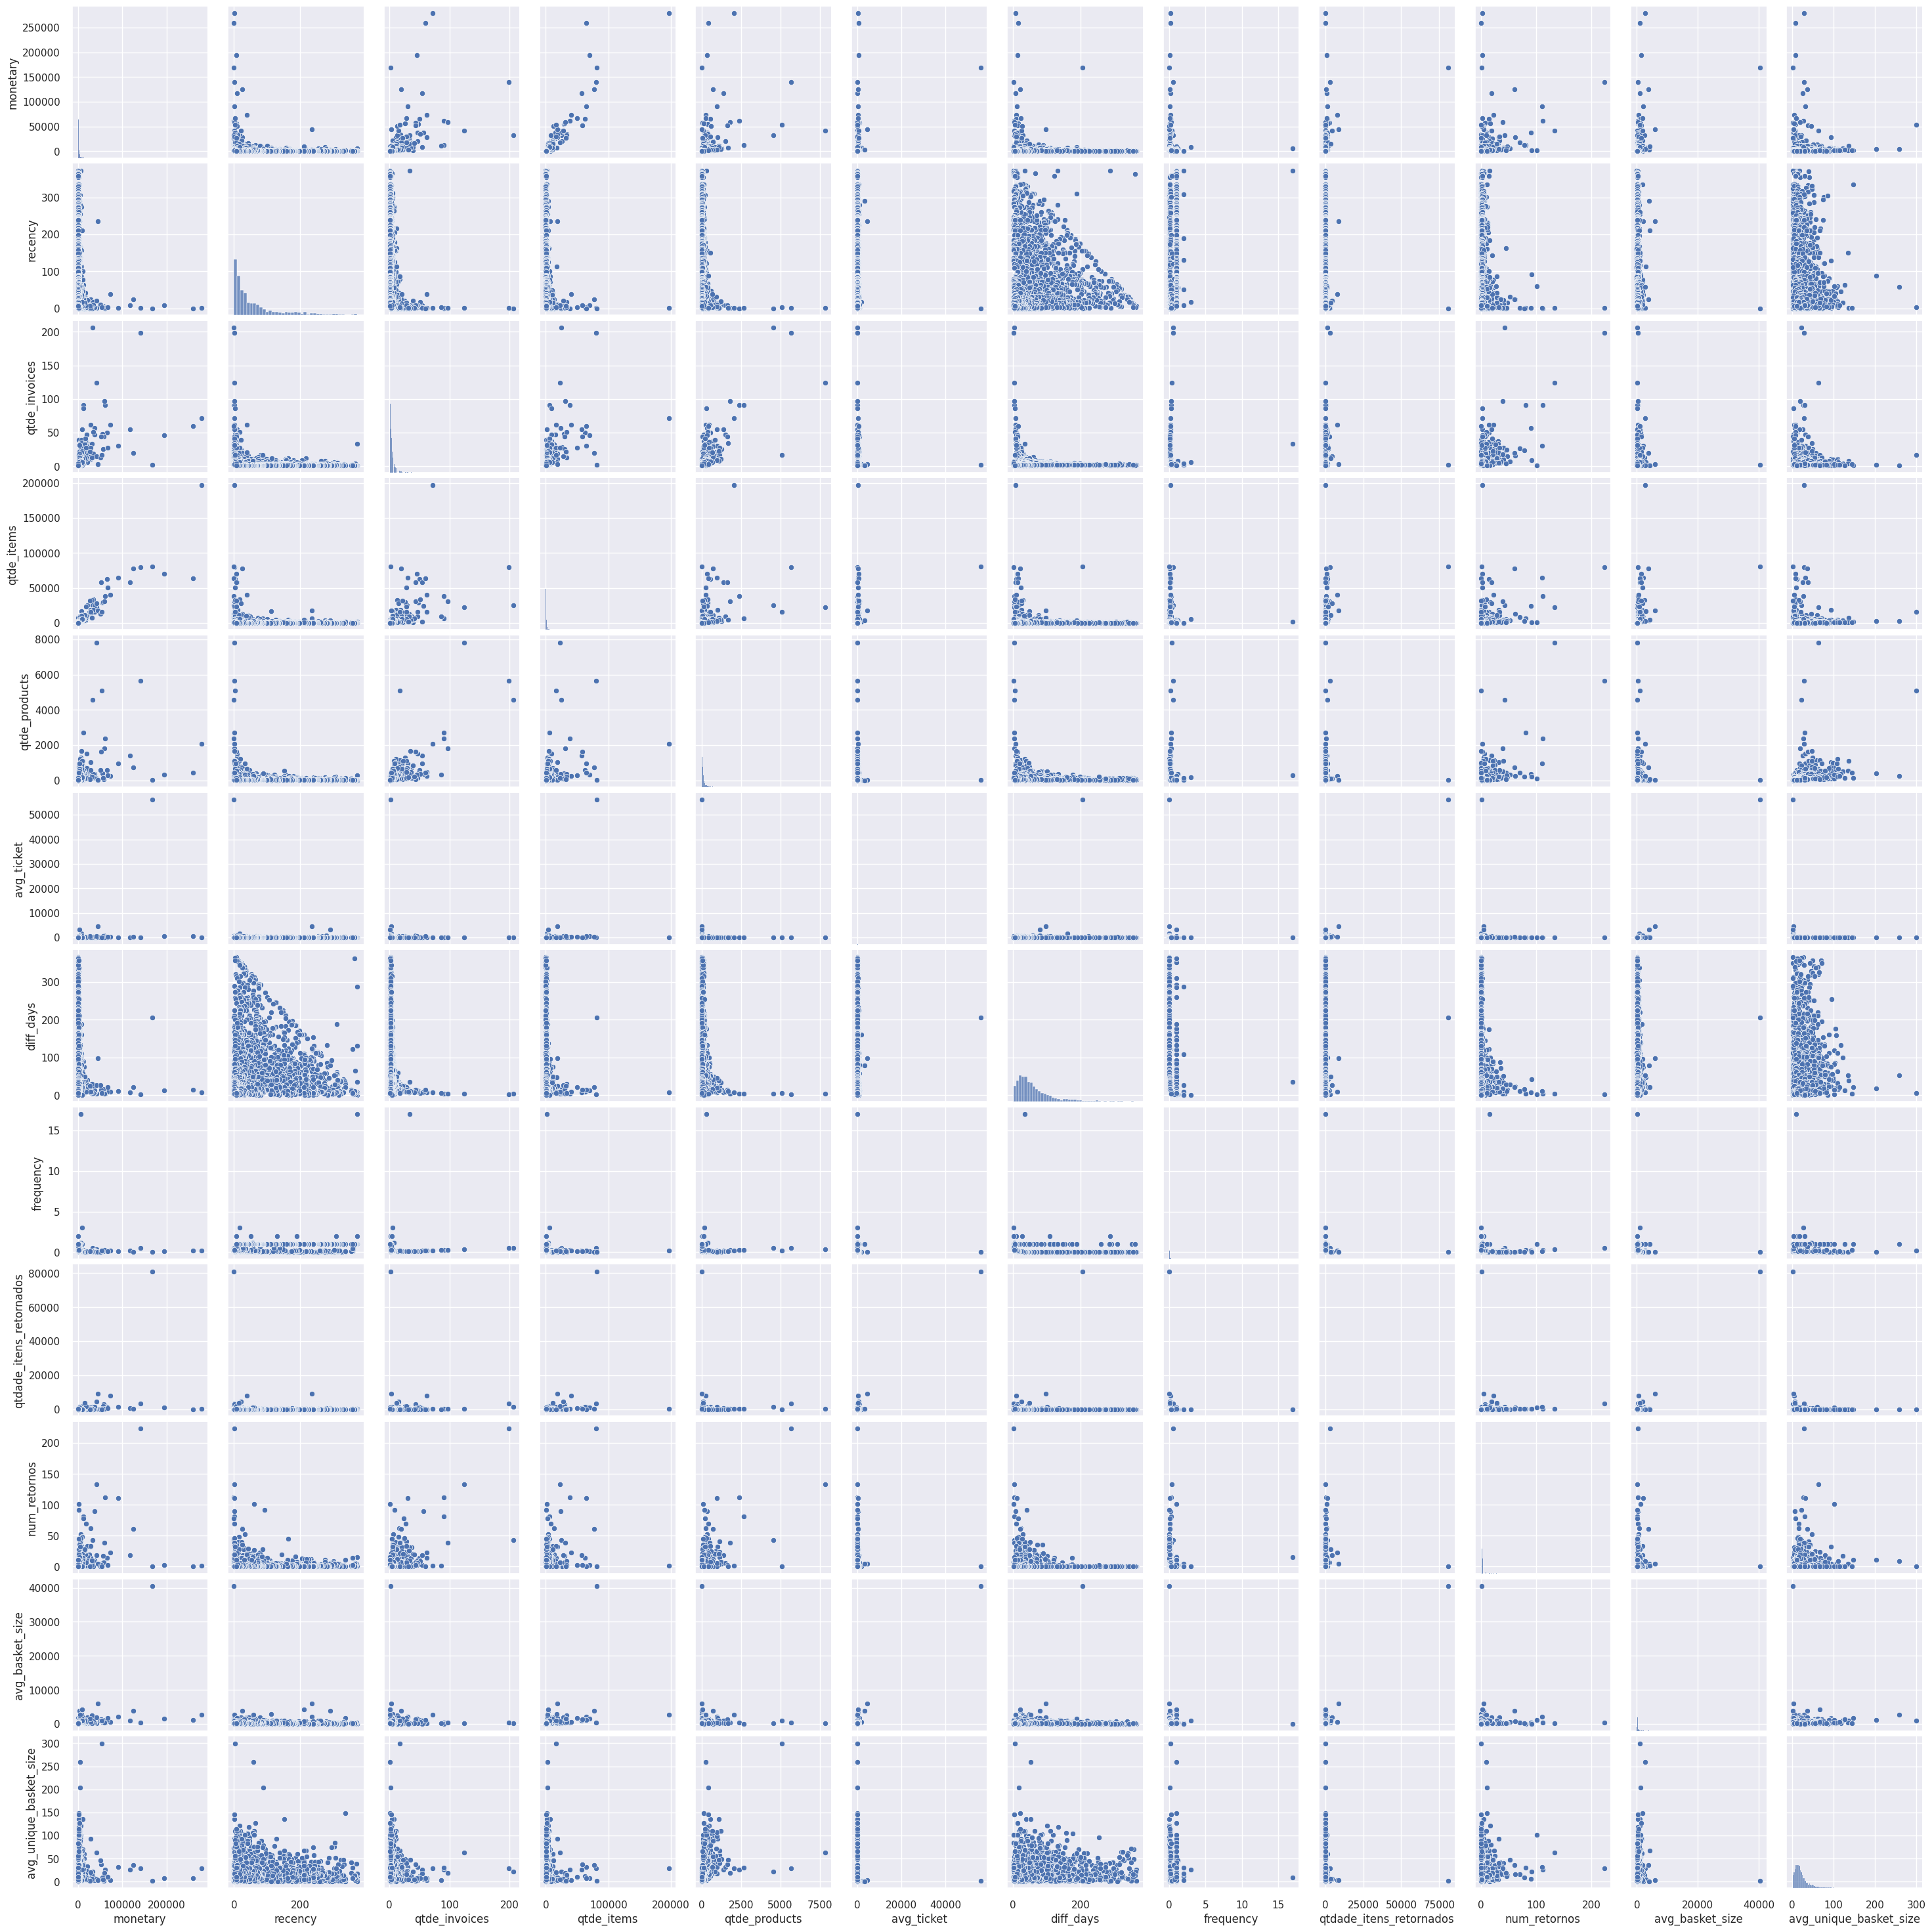

In [63]:
%%time

plt.figure(figsize=(15, 8))
sns.pairplot(df52)

In [64]:
# plt.figure(figsize=(15, 8))
# sns.pairplot(df5[['monetary', 'recency', 'qtde_invoices', 'qtde_items', 'qtde_products', 
#                     'qtde_unique_products', 'num_retornos', 'avg_basket_size']])

## 5.3. Estudo do Espaço

In [139]:
df53 = df5.drop(columns=['customer_id'], axis=1).copy()

In [140]:
minmax = MinMaxScaler()

df53['monetary']               = minmax.fit_transform(df53[['monetary']])
df53['recency']                = minmax.fit_transform(df53[['recency']])
df53['qtde_invoices']          = minmax.fit_transform(df53[['qtde_invoices']])
df53['qtde_items']             = minmax.fit_transform(df53[['qtde_items']])
df53['qtde_products']          = minmax.fit_transform(df53[['qtde_products']])
df53['avg_ticket']             = minmax.fit_transform(df53[['avg_ticket']])
df53['diff_days']              = minmax.fit_transform(df53[['diff_days']])
df53['frequency']              = minmax.fit_transform(df53[['frequency']])
df53['num_retornos']           = minmax.fit_transform(df53[['num_retornos']])
df53['avg_basket_size']        = minmax.fit_transform(df53[['avg_basket_size']])
df53['avg_unique_basket_size'] = minmax.fit_transform(df53[['avg_unique_basket_size']])

In [141]:
# X = df53.drop(columns=['qtdade_itens_retornados'], axis=1).copy()

In [142]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [143]:
X.head()

,monetary,recency,qtde_invoices,qtde_items,qtde_products,avg_ticket,diff_days,frequency,num_retornos,avg_basket_size,avg_unique_basket_size
0,0.01929,0.99732,0.16098,0.00880,0.03777,0.00028,0.09452,1.00000,0.06726,0.00123,0.02590
1,0.01156,0.15013,0.03902,0.00706,0.02169,0.00030,0.07192,0.00134,0.10314,0.00379,0.06026
2,0.02400,0.00536,0.06829,0.02554,0.02948,0.00048,0.06079,0.00205,0.01345,0.00825,0.04843
3,0.00337,0.25469,0.01951,0.00223,0.00345,0.00056,0.25114,0.00073,0.00000,0.00214,0.01540
4,0.00312,0.89276,0.00976,0.00040,0.00026,0.00516,0.02082,0.00398,0.01345,0.00063,0.00000


In [144]:
n_dim = X.shape[1]

In [145]:
print(f'Teremos um espaço de {X.shape[1]} dimensões.')

Teremos um espaço de 11 dimensões.


### 5.3.1 PCA

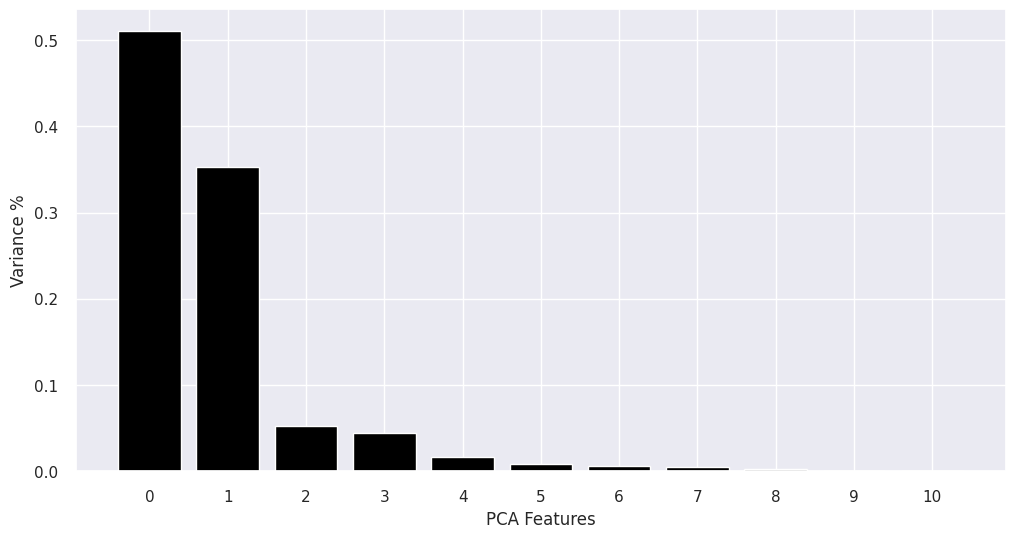

In [146]:
# Create a PCA instance
pca = PCA(n_components=n_dim)
principal_components = pca.fit_transform(X)

# Plot explained Variances
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA Features')
plt.ylabel('Variance %')
plt.xticks(features)

# Save Components to a DataFrame
df_pca = pd.DataFrame(principal_components)

In [147]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.85492,-0.02256,0.08508,0.15844,-0.09464,0.05630,0.96129,-0.01014,-0.00448,0.00180,-0.00423
1,-0.01109,-0.11694,0.01081,0.03595,-0.04409,0.06009,-0.01401,-0.01349,-0.00509,0.00320,-0.00167
2,-0.15336,-0.14329,-0.01351,0.03238,0.00181,-0.01941,0.00150,0.00669,-0.00779,-0.00513,0.00145
3,0.07603,0.07933,-0.04796,0.02441,-0.00337,-0.00910,-0.00574,0.00271,0.00033,0.00081,-0.00054
4,0.73586,-0.07614,-0.02779,0.03833,-0.00621,-0.00413,-0.02900,0.00494,0.00034,0.00268,-0.00468


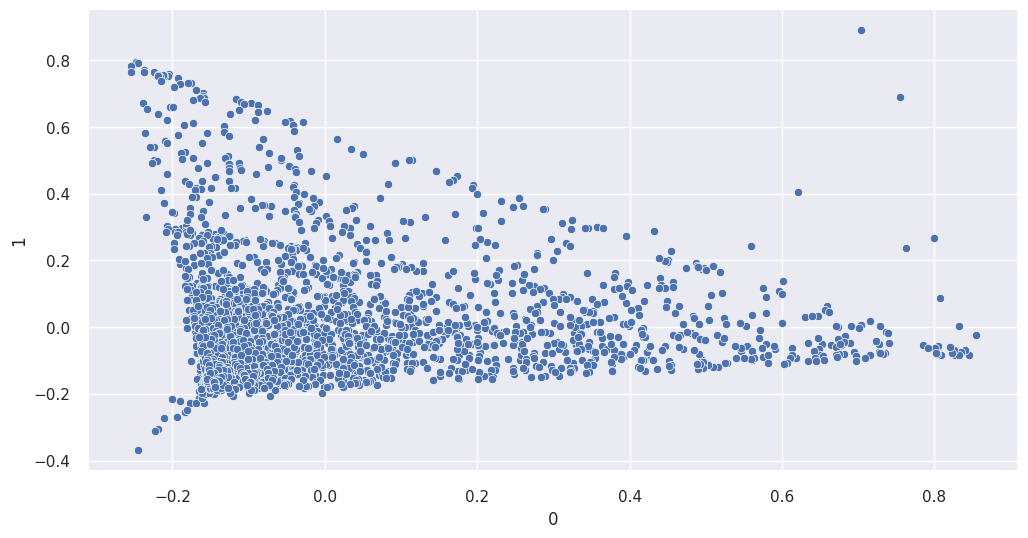

In [148]:
sns.scatterplot(x=0, y=1, data=df_pca);

### 5.3.2 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

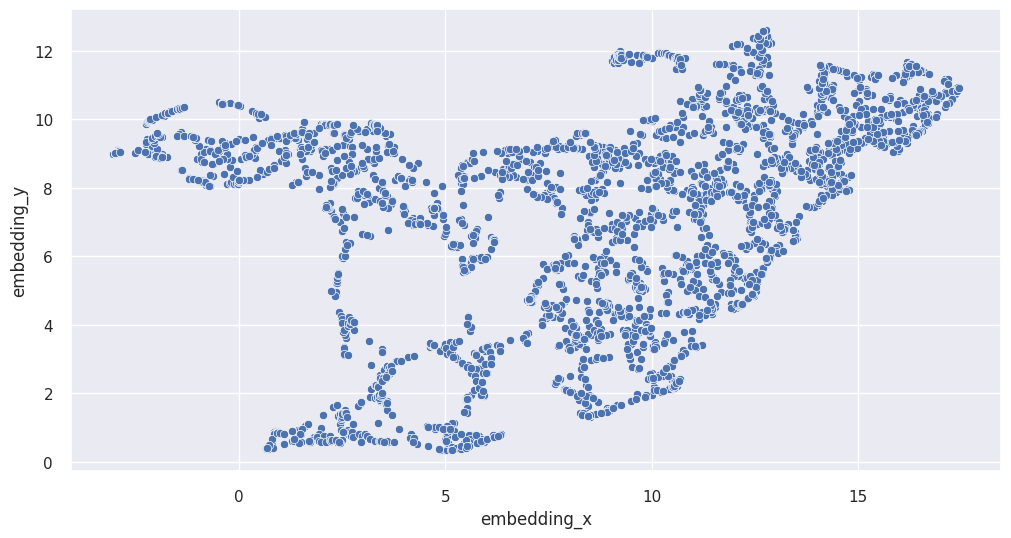

In [149]:
reducer = umap.UMAP(n_neighbors=10, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca);

### 5.3.3 t-SNE

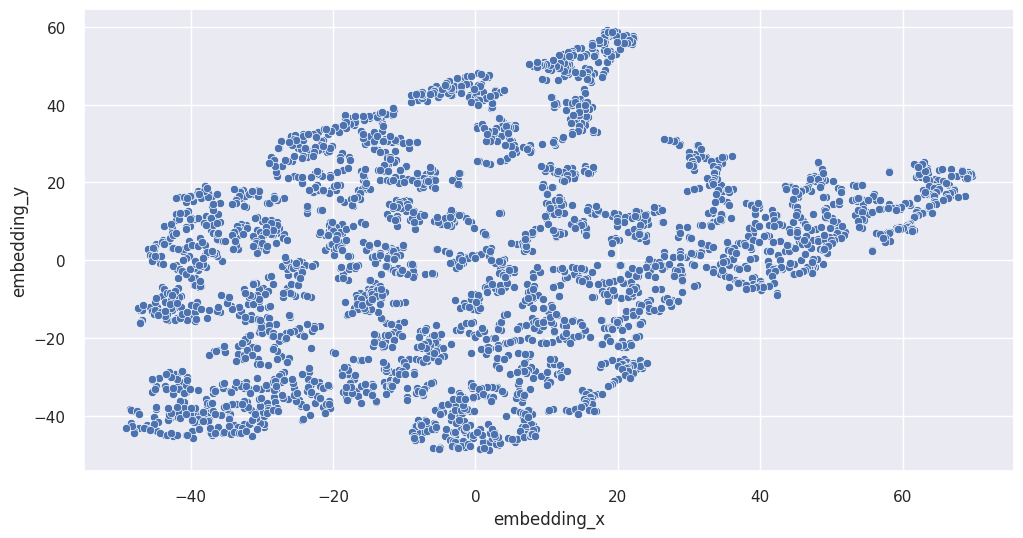

In [150]:
tsne = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = tsne.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca);

### 5.3.4 Tree-Based Embeddings

- Problema não supervisionado: precisamos definir como iremos construir esse espaço. Iremos construí-lo com uma variável que obtenhamos uma maior divisão dos clientes. Do ponto de vista de negócio, desejamos uma variável que nos permita encontrar os clientes mais valiosos. Entendemos que esta variável seria a "monetary", já que esta mede o gasto total dos clientes.

Portanto, iremos definí-la como uma variável resposta, treinar um algoritmo de árvore com todas as outras features para realizarmos a previsão desta variável e plotar um espaço de acordo com as folhas geradas pelas árvores.


In [151]:
# Definição da variável
X_tree = df5.drop(columns=['customer_id', 'monetary'], axis=1)
y = df5['monetary']

# Definição do Modelo
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treino do Modelo
rf_model.fit(X_tree, y)

# Leaf
# rf_model.apply(X_tree)

# DataFrame Leaf

RandomForestRegressor(random_state=42)

In [152]:
df_leaf = pd.DataFrame(rf_model.apply(X_tree))

In [153]:
X_tree.shape, df_leaf.shape

((2969, 11), (2969, 100))

In [154]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2984,2726,3394,3325,3020,3313,3231,3140,3183,3009,3171,3099,3154,3168,2800,3087,3024,3191,3083,3288,2836,2672,2891,3300,3307,3122,3063,3226,3107,3177,3033,3391,3369,2992,2961,3041,3416,3105,2951,3111,3351,3151,3432,3135,3176,3153,2858,3345,3349,3159,3197,3206,3161,3401,3391,3192,3157,3363,3118,3324,3418,2938,3338,3239,2880,3281,3299,3324,3040,3282,3338,2945,3298,2975,3155,3169,2971,3012,3216,3159,3135,3331,3182,3094,3289,3150,3293,3326,3137,3263,3242,3227,3222,2802,3211,3114,3031,3368,3341,3326
1,2935,3112,3029,2899,3028,2978,2938,2807,3113,2947,3122,3053,3083,3146,2750,3120,2970,3070,3041,2419,3173,3103,2829,2839,2954,3115,2926,2758,3029,3141,2980,3018,2971,2973,2918,2958,2960,2837,3058,2915,2869,2800,2995,3115,3125,2582,3012,2879,3010,2919,3171,3122,3077,2963,2998,2940,2801,3021,3065,2912,2992,2909,2909,2861,2856,2900,2949,2967,2957,2956,2962,2874,2910,2898,3106,2509,2912,2909,3175,3150,3024,2924,3179,2780,2902,3136,2953,2984,3099,2836,2501,2550,2951,2757,3128,3011,2937,2893,2793,2835
2,3499,3616,3520,3405,3587,3636,3542,3546,3701,3615,3508,3591,3531,3627,3514,3556,3580,3632,3621,3477,3519,3653,3606,3504,3531,3595,3495,3623,3513,3722,3434,3681,3605,3633,3581,3632,3548,3502,3594,3483,3647,3399,3693,3616,3528,3590,3580,3632,3473,3602,3500,3496,3611,3618,3682,3642,3613,3647,3538,3483,3535,3614,3589,3658,3471,3603,3615,3640,3618,3616,3587,3598,3563,3603,3614,3549,3575,3533,3604,3595,3516,3458,3543,3489,3599,3628,3583,3701,3531,3393,3603,3461,3567,3544,3617,3562,3587,3621,3592,3666
3,2224,1967,1574,1433,1923,2217,2117,1790,2073,1748,2069,1513,1263,1606,1520,1790,1876,1591,1447,1429,1829,1251,1442,1573,2206,1989,1504,1853,1429,1516,1832,1552,1365,1566,1430,1864,2202,1777,1428,1718,1837,1858,1370,1718,1839,1497,1535,1385,2053,1235,1599,1567,1345,2190,2100,2027,1415,1773,1473,2062,1577,1504,1938,1835,1494,1514,2136,1837,1538,2074,2322,1613,1526,1543,1531,1319,2047,1547,1956,1950,2120,1416,1690,1554,2228,1569,1223,2161,1328,1490,1834,1434,2054,2062,1437,2271,1529,1442,2088,2279
4,218,270,298,596,175,712,727,692,174,165,598,162,776,953,622,179,199,210,700,696,164,705,467,212,649,197,387,528,139,760,699,866,199,339,220,620,338,197,538,586,741,522,450,606,727,550,935,663,699,622,612,963,738,566,564,575,238,717,727,583,231,246,557,190,665,438,568,735,701,603,584,190,351,841,177,197,592,587,605,183,197,332,569,334,588,216,686,853,207,808,423,218,679,586,696,741,200,902,696,207


In [155]:
df_leaf.shape

(2969, 100)

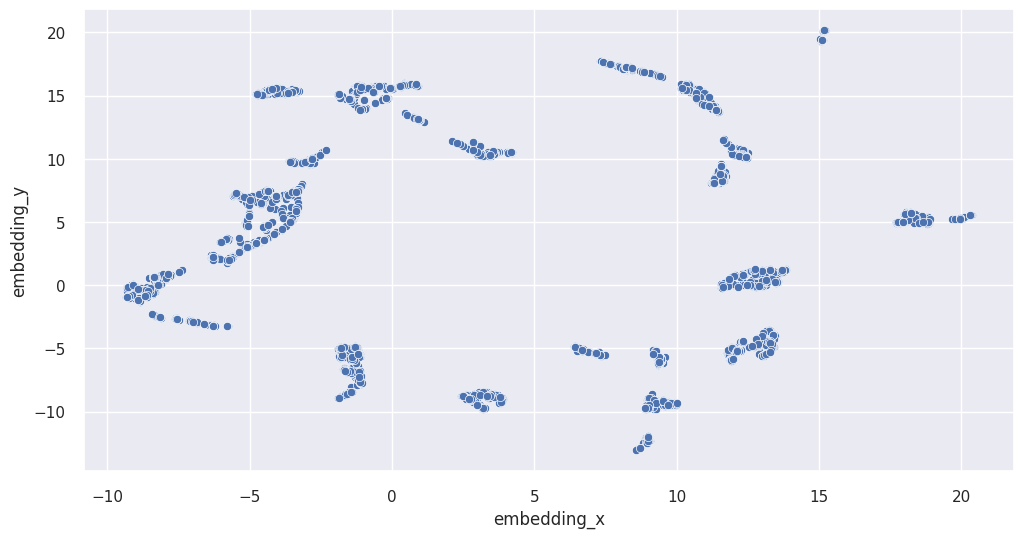

In [157]:
# Dimensionalidade Reduzida
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# Plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca);

# 6.0 Data Preparation & Feature Selection

In [46]:
df6 = df5.copy()

In [57]:
# Standard Scaler
ss = StandardScaler()

df6['monetary']   = ss.fit_transform(df6[['monetary']]  )
df6['recency']    = ss.fit_transform(df6[['recency']]   )
df6['frequency']  = ss.fit_transform(df6[['frequency']] )
df6['avg_ticket'] = ss.fit_transform(df6[['avg_ticket']])

In [58]:
df6.head()

,customer_id,monetary,recency,frequency,avg_ticket
0,17850,0.38,2.79,3.89,-0.03
1,13047,0.14,-0.36,0.62,-0.03
2,12583,0.53,-0.90,1.41,-0.03
3,13748,-0.12,0.03,0.10,-0.02
4,15100,-0.13,2.40,-0.16,0.15


# 7.0 Hyperparameter Fine-tuning

In [59]:
X = df6.drop(columns=['customer_id'])

In [60]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluster Sum of Square (WSS)

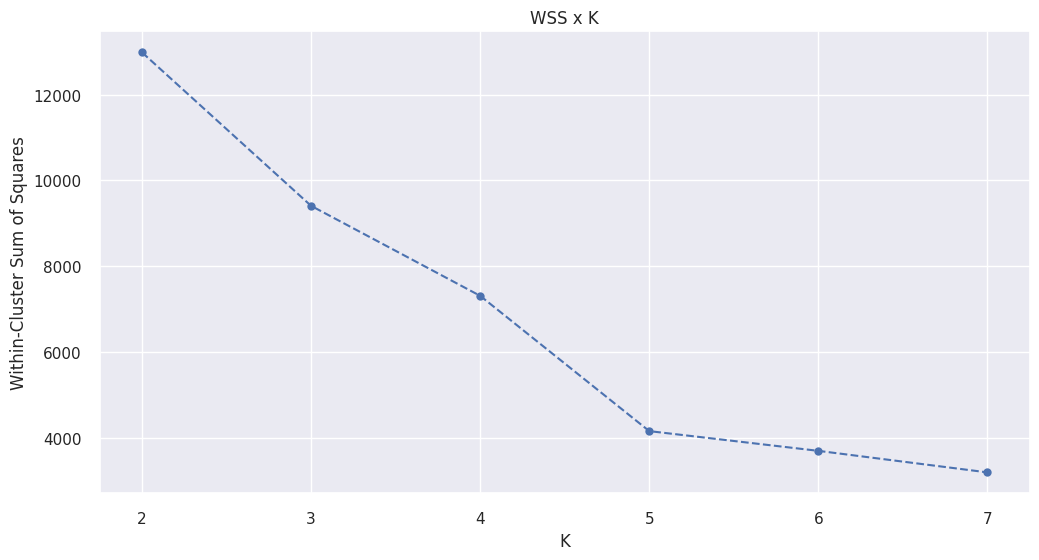

In [61]:
wss = []
for k in clusters:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=CFG.seed)
    
    # model training
    kmeans.fit(X)
    
    # validation    
    wss.append(kmeans.inertia_)

# plot wss - Elbow Method - Método Cotovelo
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('WSS x K');

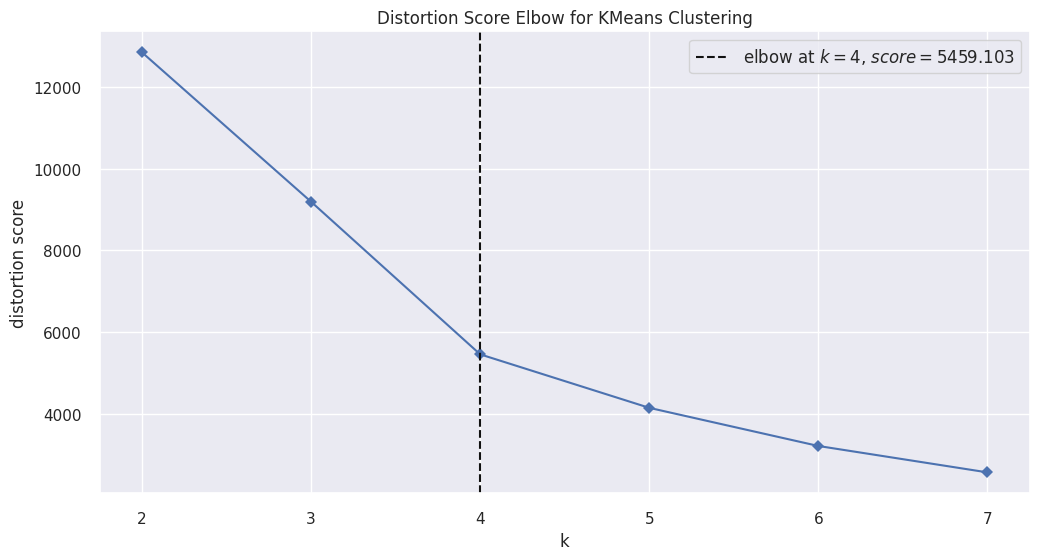

In [62]:
kmeans = KElbowVisualizer(KMeans(n_init=10), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score

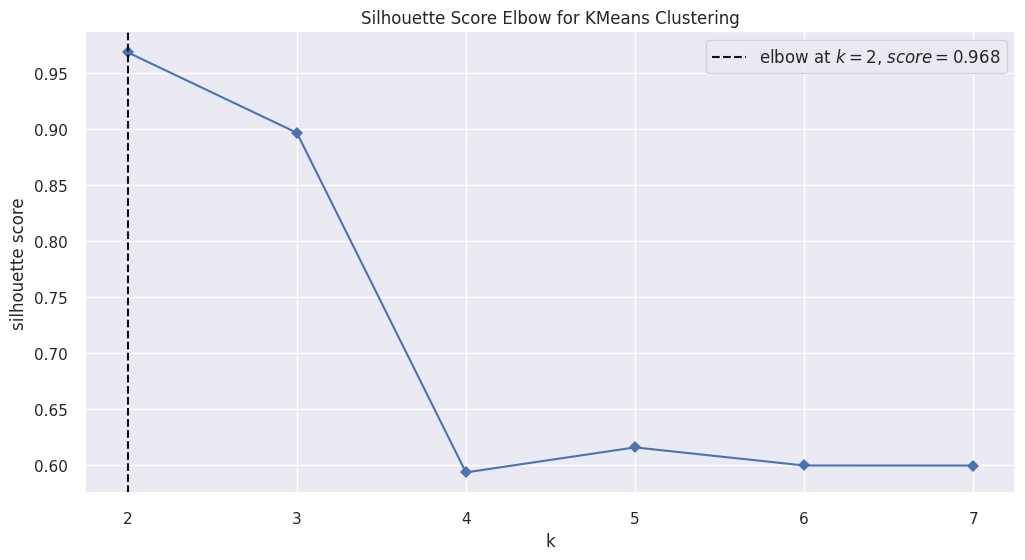

In [63]:
kmeans = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit(X)
kmeans.show();

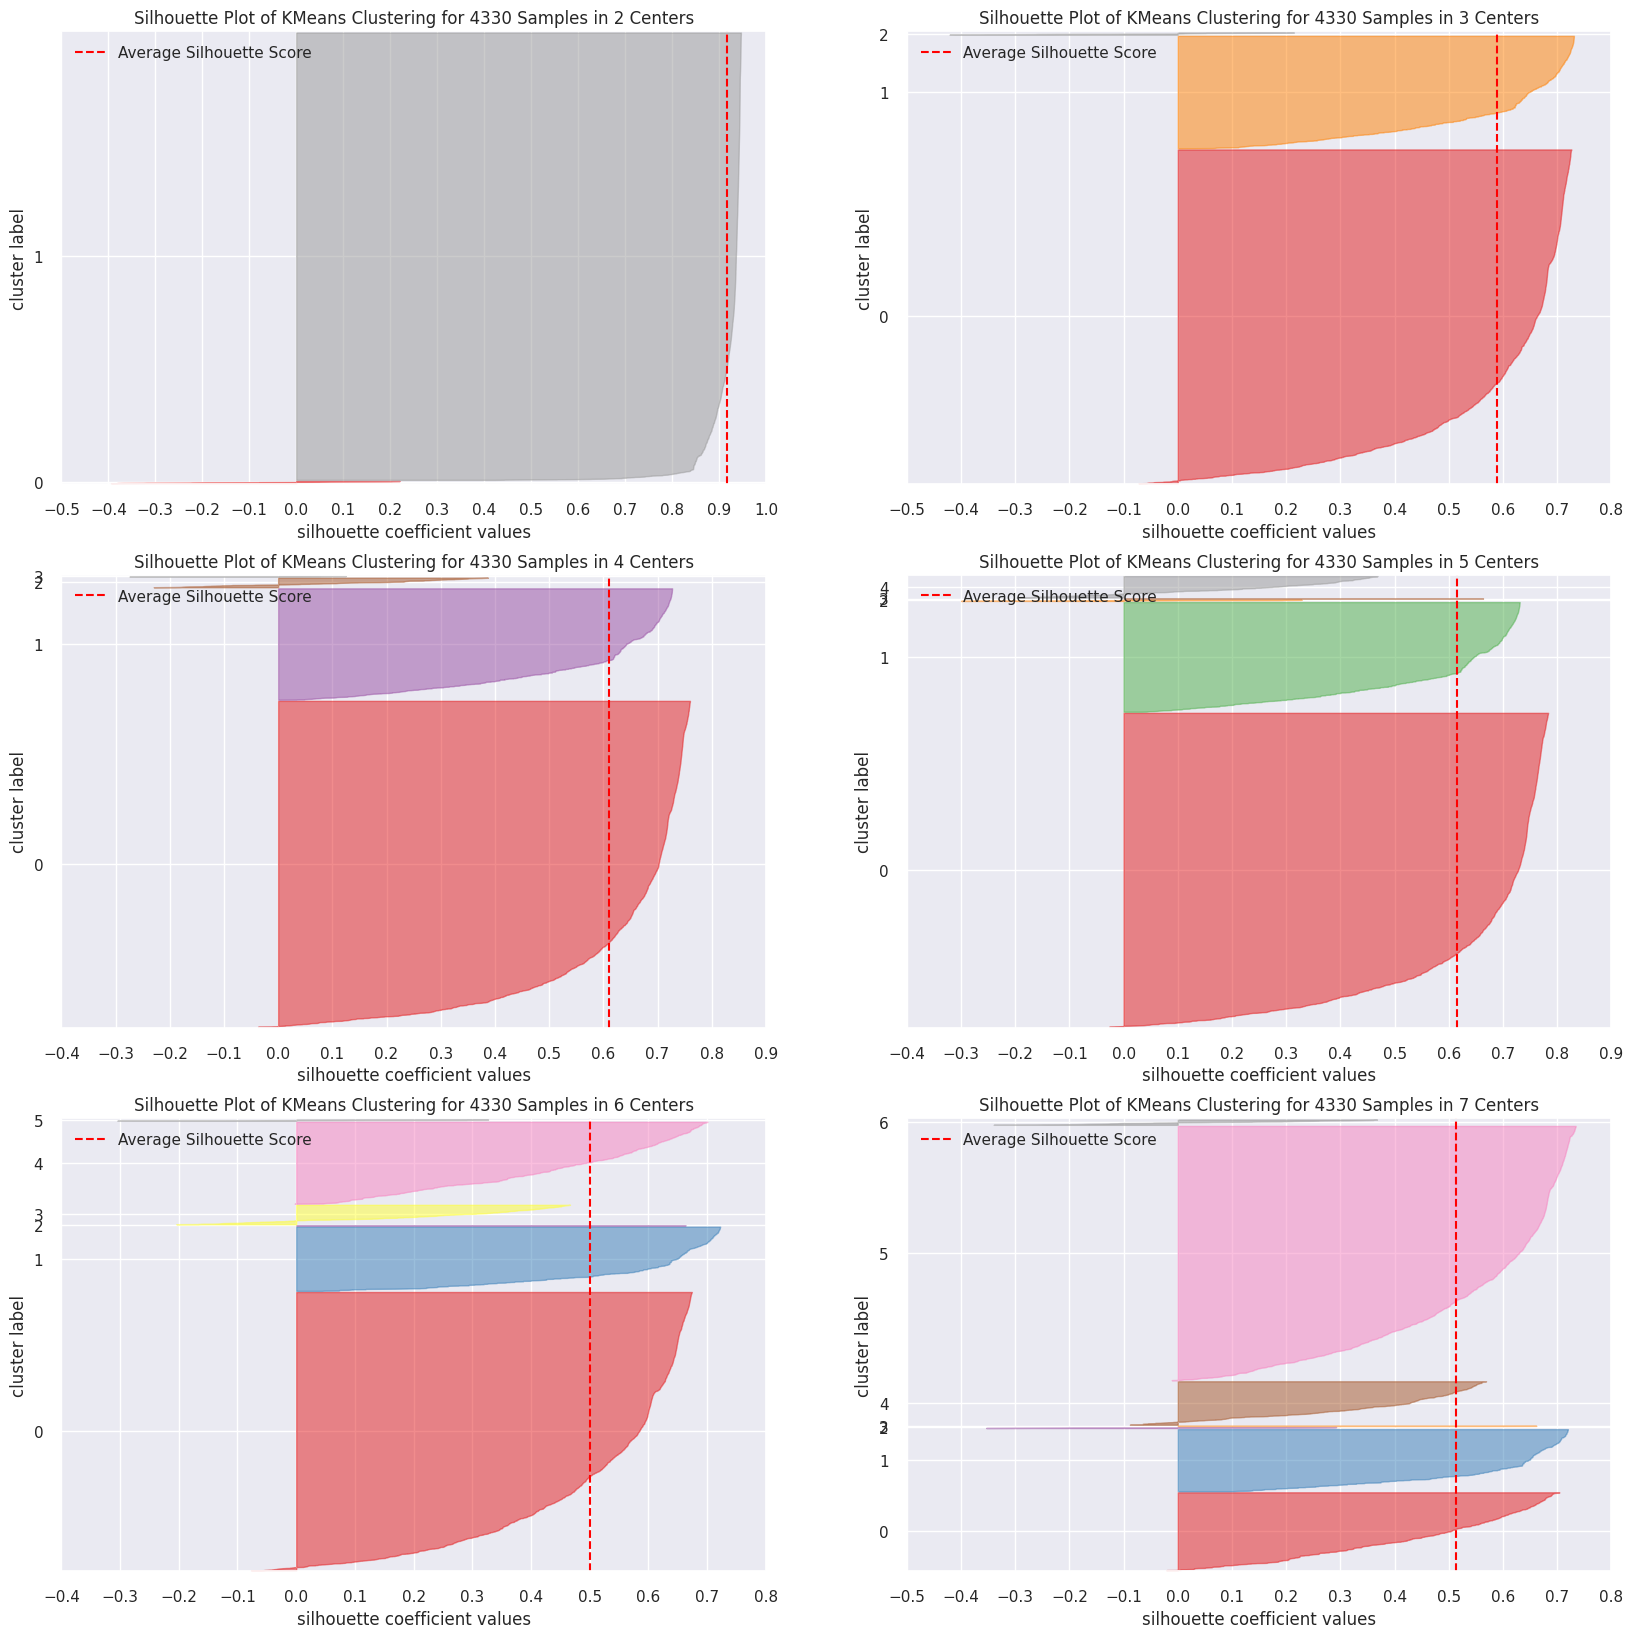

In [64]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))

for k in clusters:
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=CFG.seed)
    q, mod = divmod(k, 2)
    viz = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    viz.fit(X)
    viz.finalize()

# 8.0 Model Training

## 8.1. K-Means

In [65]:
# model definition
k = 3
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.predict(X) # ou kmeans.labels_

## 8.2. Cluster Validation

In [66]:
## WSS 
print(f'WSS value:{kmeans.inertia_}')

## SS
print(f'SS value: {silhouette_score(X, labels, metric="euclidean")}')

WSS value:9408.255050647302
SS value: 0.5893633811956627


# 9.0 Cluster Analysis

In [71]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,monetary,recency,frequency,avg_ticket,cluster
0,17850,0.38,2.79,3.89,-0.03,1
1,13047,0.14,-0.36,0.62,-0.03,2
2,12583,0.53,-0.90,1.41,-0.03,2
3,13748,-0.12,0.03,0.10,-0.02,2
4,15100,-0.13,2.40,-0.16,0.15,1


## 9.1. Visualization Inspection

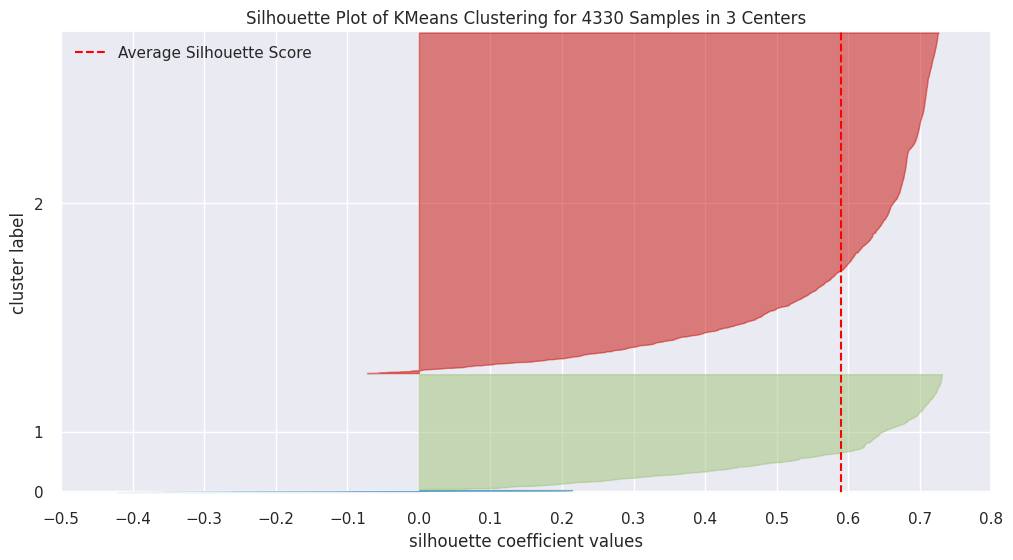

In [67]:
viz = SilhouetteVisualizer(kmeans, colors='yellowbrick')
viz.fit(X)
viz.finalize()

## 9.2. Two-Dimensional Plot

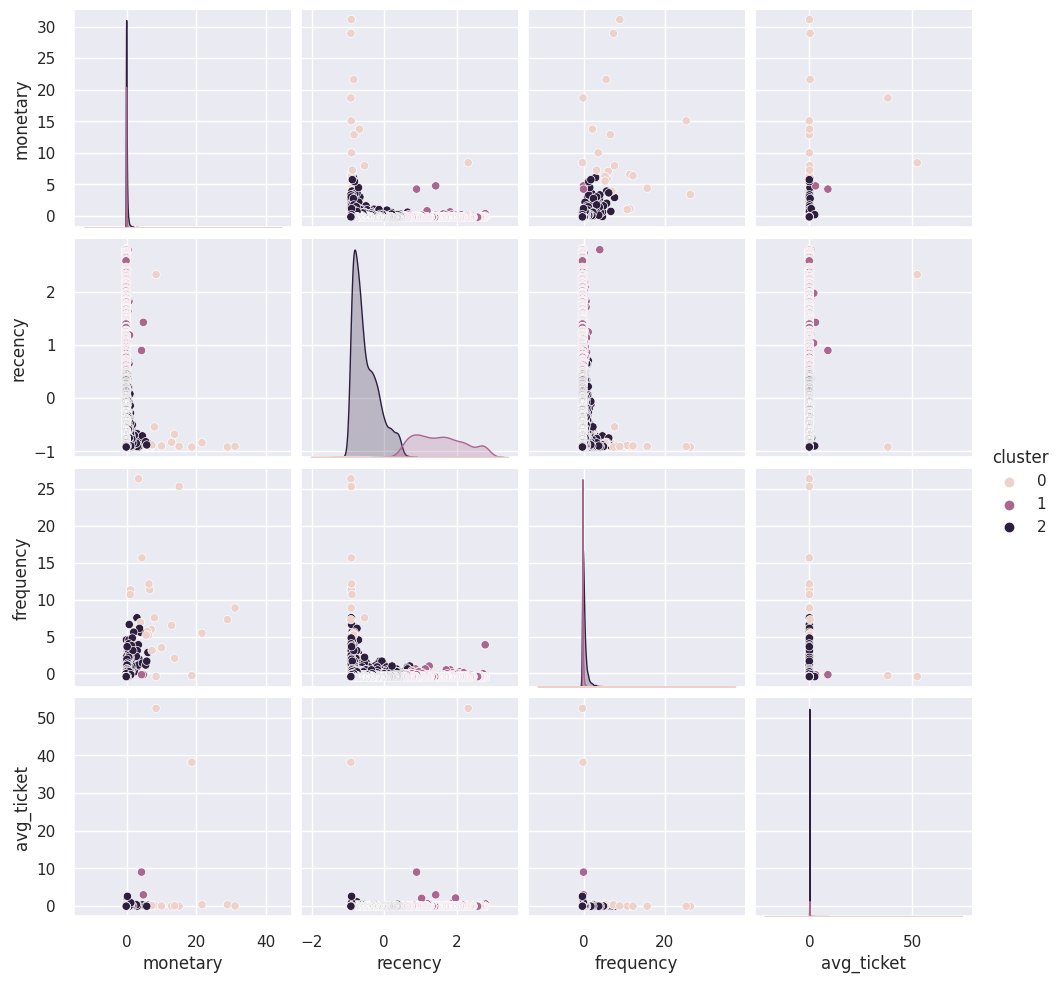

In [72]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster');

## 9.3. UMAP

In [68]:
X.head()

,monetary,recency,frequency,avg_ticket
0,0.38,2.79,3.89,-0.03
1,0.14,-0.36,0.62,-0.03
2,0.53,-0.90,1.41,-0.03
3,-0.12,0.03,0.10,-0.02
4,-0.13,2.40,-0.16,0.15


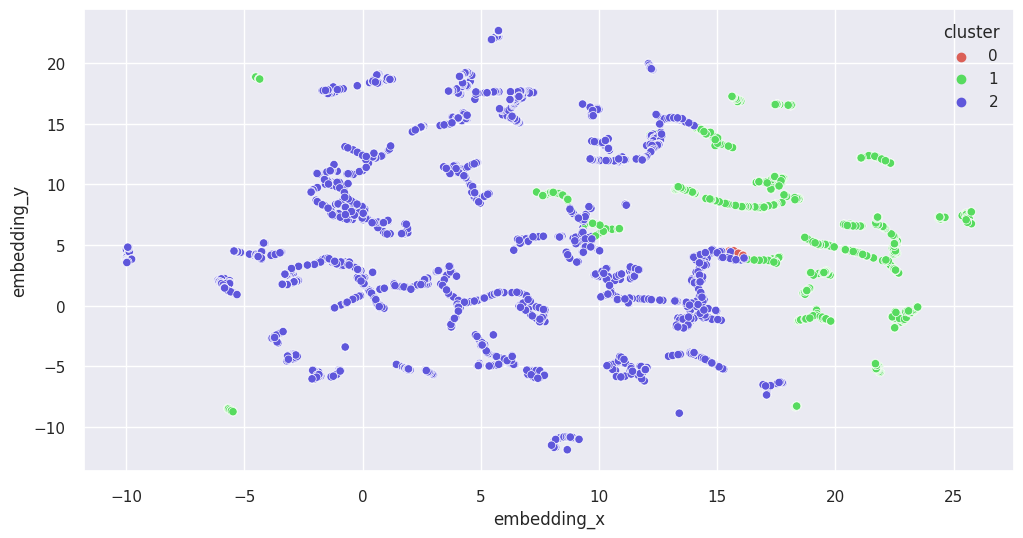

In [75]:
reducer = umap.UMAP(n_neighbors=5, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=df_viz['cluster'].nunique()),
               data=df_viz);

In [76]:
## fig = px.scatter_3d(df9, x='recency', y='frequency', z='monetary', color='cluster')
# fig.show()

## 9.4. Cluster Profile

In [77]:
df9.head()

,customer_id,monetary,recency,frequency,avg_ticket,cluster
0,17850,0.38,2.79,3.89,-0.03,1
1,13047,0.14,-0.36,0.62,-0.03,2
2,12583,0.53,-0.90,1.41,-0.03,2
3,13748,-0.12,0.03,0.10,-0.02,2
4,15100,-0.13,2.40,-0.16,0.15,1


In [78]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = (df_cluster['customer_id'] / df_cluster['customer_id'].sum())*100

# Avg Monetary
df_avg_monetary = df9[['monetary', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_monetary, on='cluster')

# Avg recency days
df_avg_recency = df9[['recency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, on='cluster')

# Avg frequency
df_avg_frequency = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, on='cluster')

df_cluster

,cluster,customer_id,perc_customer,monetary,recency,frequency,avg_ticket
0,0,22,0.51,10.33,-0.72,8.44,4.19
1,1,1086,25.08,-0.16,1.54,-0.35,-0.01
2,2,3222,74.41,-0.02,-0.51,0.06,-0.03


**Exemplo de leitura da tabela:**

- No cluster 1: composto por 6 pessoas, que gastaram 182.000 dólares em média, com uma recência média super baixa, pois compram a cada 7 dias (compram toda semana), comprando em média 90 produtos.

### Cluster 01:  (Premium - Candidato à Insider)
    - Número de customers: 6 (0,14% dos clientes)
    - Recência média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: U$ 182.182,00 
    
### Cluster 02: (VIPs)
    - Número de customers: 31 (0,71% dos clientes)
    - Recência média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: U$ 40.543,52 
    
### Cluster 03: (Ocasionais)
    - Número de customers: 4.335 (99% dos clientes)
    - Recência média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: U$ 1.372,57 


# 10.0 Deployment

# 11.0 SandBox

## 11.1. Original Dataset

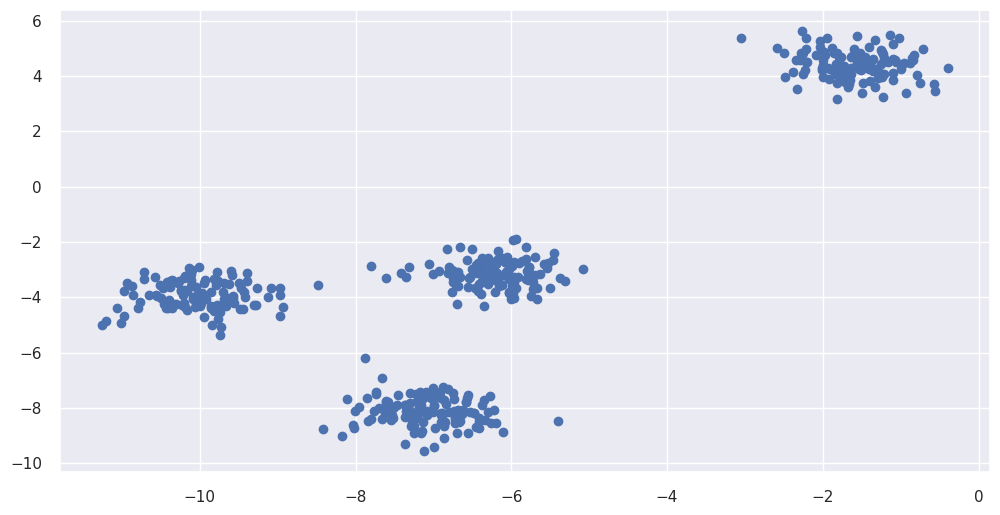

In [49]:
from sklearn.datasets import make_blobs #cria pontos no espaço

X, y = make_blobs(n_samples=500, n_features=2, 
                  centers=4,
                  cluster_std=0.5,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=CFG.seed)
# plot dataset
plt.scatter(X[:, 0], X[:, 1])

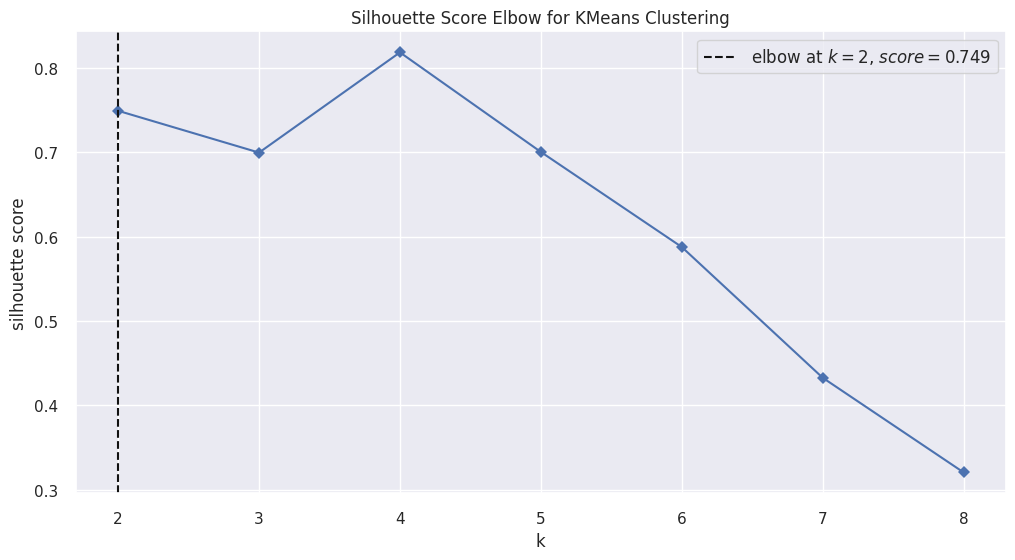

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [50]:
# modeling
clusters = list(range(2, 9))
kmeans = KElbowVisualizer(KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

## 11.2. Silhouette Analysis

IndexError: index 2 is out of bounds for axis 0 with size 2

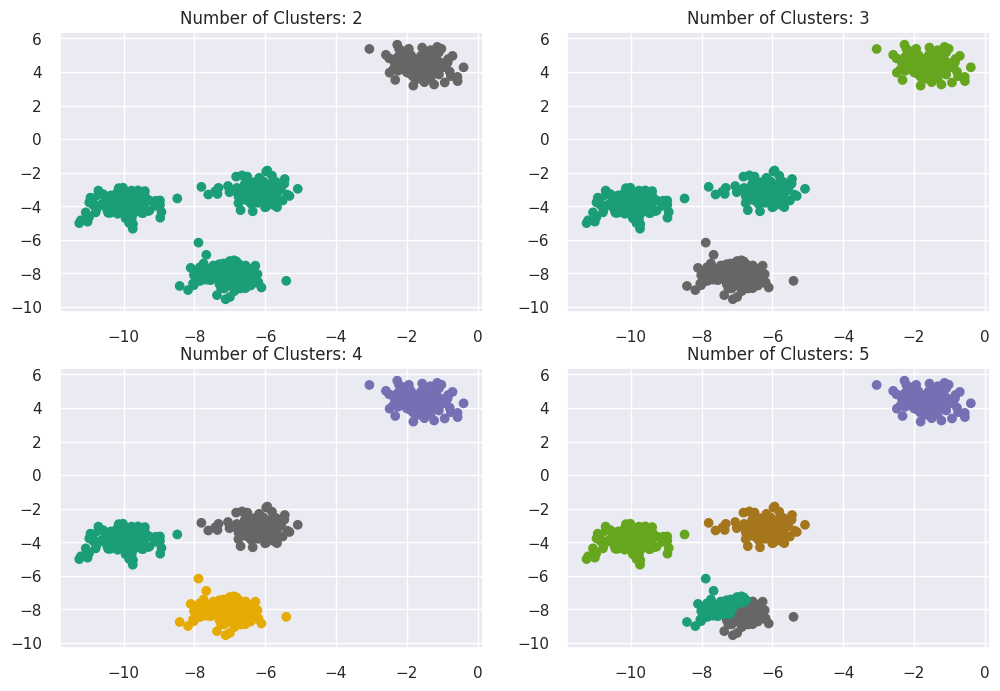

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
for i in clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=CFG.seed)
    kmeans.fit(X)
    
    q, mod = divmod(i, 2)
    ax[q-1, mod].scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap=plt.cm.Dark2)
    ax[q-1, mod].set_title('Number of Clusters: {}'.format(i))
plt.show()

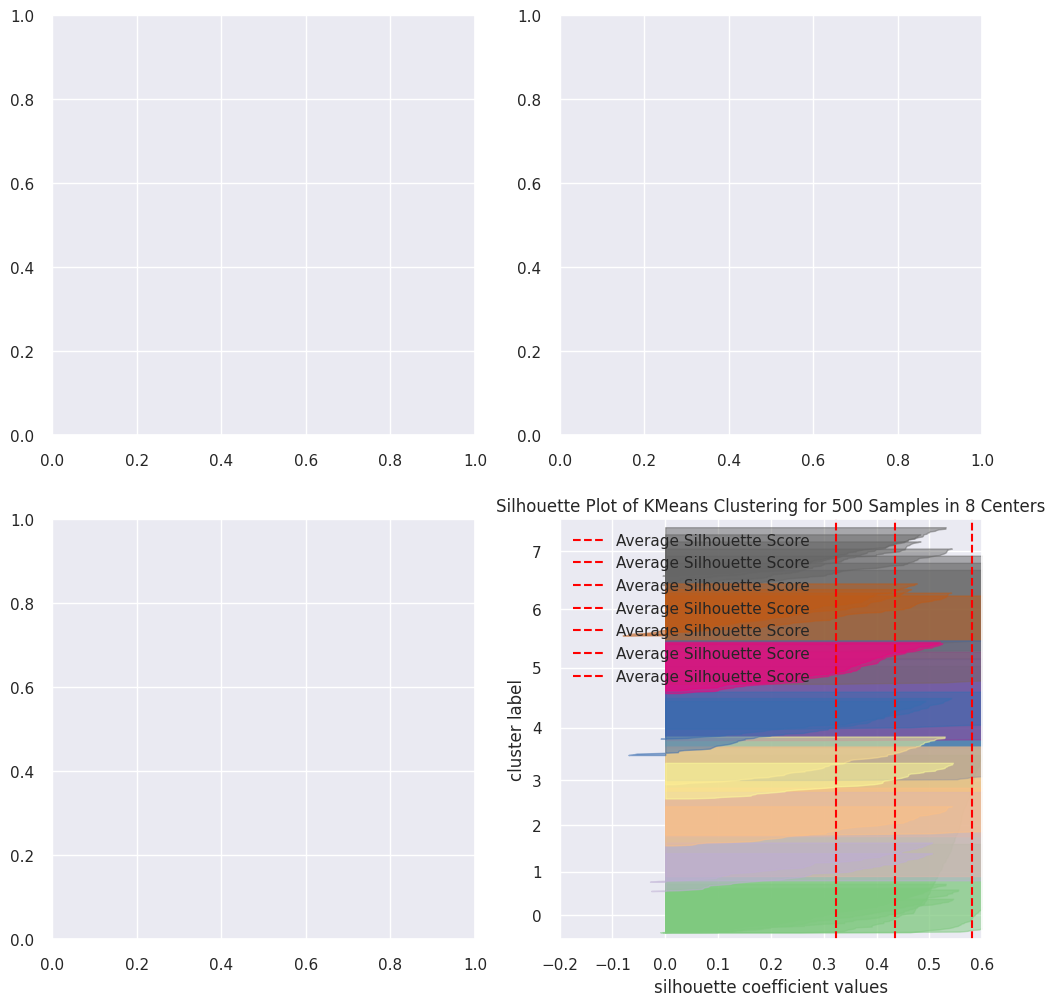

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
for i in clusters:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=CFG.seed)
    q, mod = divmod(i, 2)
    
    visualizer = SilhouetteVisualizer(kmeans, colors='Accent')
    visualizer.fit(X)
    visualizer.finalize()